In [1]:
%matplotlib notebook

from neurodiffeq import diff
from neurodiffeq.solvers import Solver1D, Solver2D
from neurodiffeq.conditions import IVP, DirichletBVP2D
from neurodiffeq.networks import FCNN, SinActv
from neurodiffeq.monitors import Monitor1D

from scipy import special
from scipy.stats import norm
import numpy as np

import torch
import pdb

In [2]:
def kernel(r):
    p = special.hermite(4, monic=False)
    return .25 * p(r/np.sqrt(2)) * norm.pdf(r,0,1)

def indexToCoord(i):
    nOneDimension = int(np.sqrt(nOsc))
    x = i % nOneDimension
    y = np.floor(i/nOneDimension)
    return np.array([x,y])
    
def distance(x0, x1):
    coord0 = indexToCoord(x0)
    coord1 = indexToCoord(x1)
    return np.linalg.norm(coord0 - coord1)

def extendedKernelMatrixGet():
    extendedKernelMatrix = np.zeros(shape=(nOsc, nOsc))
    for i in range(nOsc):
        for j in range(i,nOsc):
            r = distance(i,j)
            extendedKernelMatrix[i,j] = (K/nOsc) * kernel(r)
            extendedKernelMatrix[j,i] = extendedKernelMatrix[i,j]
    return extendedKernelMatrix
    
'''
def sinDiffGet(theta):
    A = torch.zeros(size=(nOsc, nOsc))
    for i in range(nOsc):
        for j in range(i, nOsc):
            A[i,j] = theta[i] - theta[j]
            A[j,i] = -A[i,j]
    A = torch.sin(A)
    return A

def kuramoto2d(t, theta):
    sinDiff = sinDiffGet(theta)
    thetaDot = W + np.sum(np.dot(extendedKernelMatrix.transpose(),sinDiff), axis=1)
    return thetaDot
'''

def kuramoto2dNeural(*thetaStar):
    theta = thetaStar[0:-1]
    thetaTensor = torch.cat(theta,1)
    t = thetaStar[-1]
    a = [diff(theta[i],t) 
         - W[i] 
         - torch.matmul(torch.sin(thetaTensor - theta[i]), extendedKernelMatrix[:,i]) 
         for i in range(nOsc)]
    return a

In [3]:
# set these simulation parameters
nOsc = 100
upperTimeBound = 10
K = 20

# theta0, W are initial phase, intrinsic freq
theta0 = np.random.uniform(low=0.0, high=2*np.pi, size=nOsc)
W = torch.normal(0, .5, (nOsc,1))

extendedKernelMatrix = torch.tensor(extendedKernelMatrixGet().transpose())

<IPython.core.display.Javascript object>


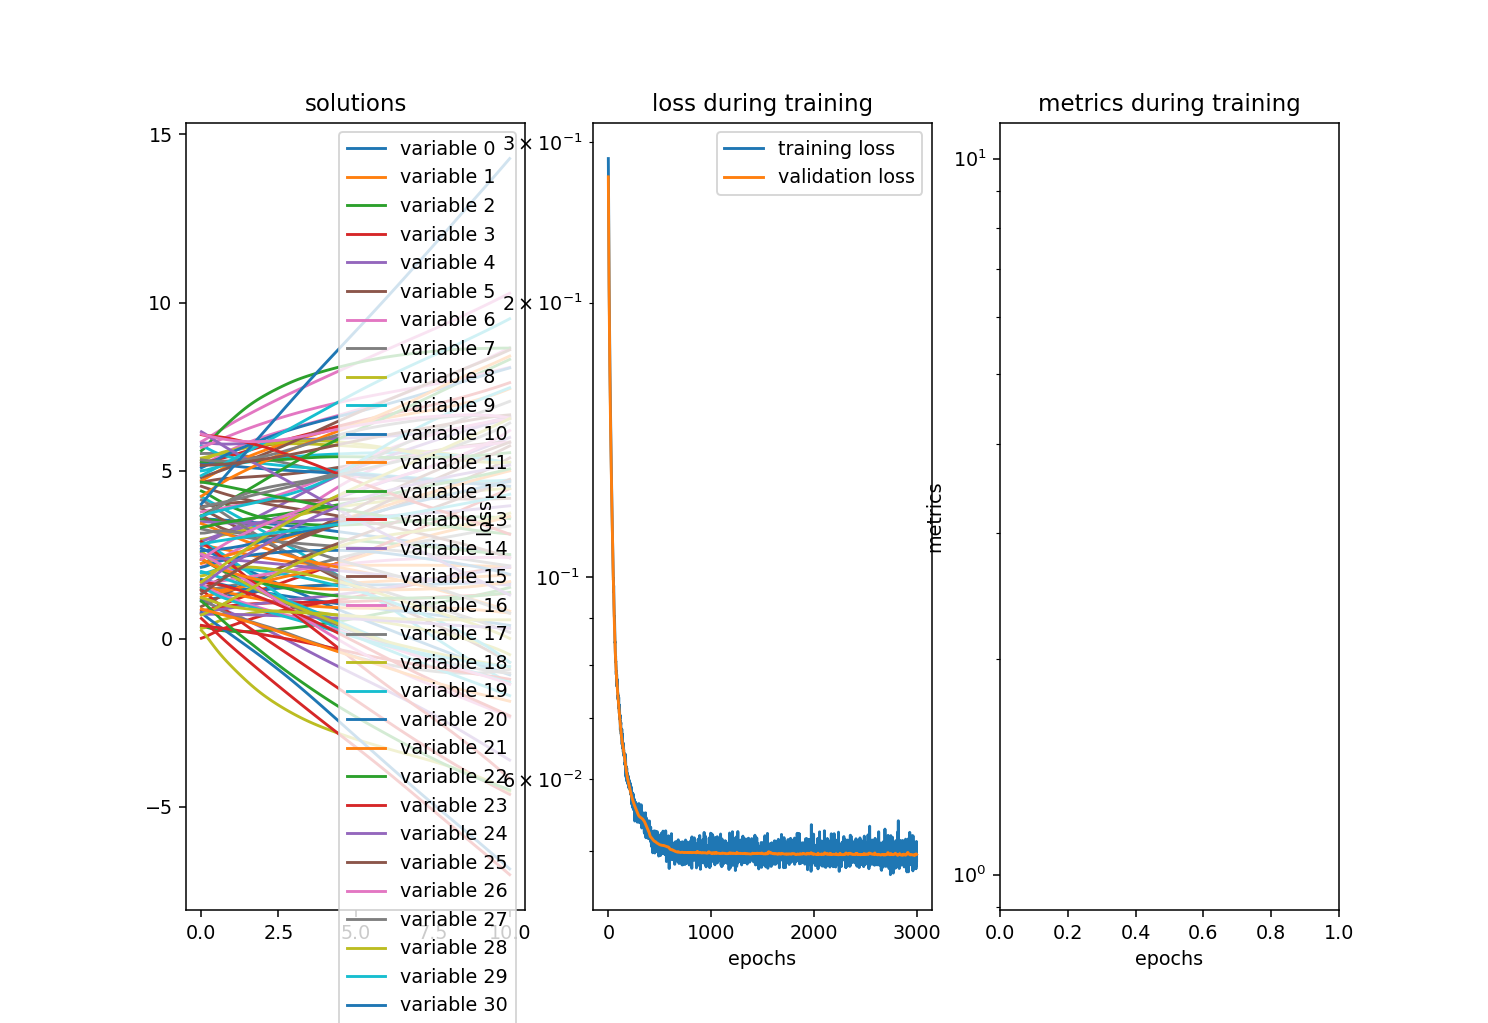

Training Progress:   0%|                                                                    | 0/3000 [00:00<?,…

In [4]:
monitor = Monitor1D(t_min=0.0, t_max=10.0, check_every=100)
monitor_callback = monitor.to_callback()

conditions = [IVP(t_0=0.0, u_0=i) for i in theta0]
nets = [FCNN(actv=SinActv) for i in range(nOsc)]

solver = Solver1D(kuramoto2dNeural, conditions, t_min=0.0, t_max=upperTimeBound, nets=nets)
solver.fit(max_epochs=3000, callbacks=[monitor_callback])
solution = solver.get_solution()

In [ ]:
'''
def ode_system(u, v, t): 
    return [diff(u,t)-(u-u*v), diff(v,t)-(u*v-v)]
'''

def ode_system(*x):
    pdb.set_trace()
    a = [diff(x[0],x[2])-(x[0]-x[0]*x[1]), diff(x[1],x[2])-(x[0]*x[1]-x[1])]
    return a
    
conditions = [IVP(t_0=0.0, u_0=1.5), IVP(t_0=0.0, u_0=1.0)]
nets = [FCNN(actv=SinActv), FCNN(actv=SinActv)]

solver = Solver1D(ode_system, conditions, t_min=0.1, t_max=12.0, nets=nets)
solver.fit(max_epochs=3000)
solution = solver.get_solution()

In [ ]:
solution.nets